# Monte Carlo a Catena di Markov {#sec-metropolis}

**Prerequisiti**

- Leggere l'@sec-montecarlo-integration.
- Leggere l'@sec-appendix-markov-first-order.

**Concetti e competenze chiave**

- Utilizzare metodi di Monte Carlo per stimare valori attesi e probabilità, evitando calcoli di integrali complessi.
- Apprendere il ruolo delle catene di Markov per generare sequenze di campioni dalla distribuzione a posteriori.
- Implementare e comprendere l'algoritmo di Metropolis come strumento per il campionamento dalla distribuzione a posteriori.
- Valutare la convergenza delle catene di Markov e utilizzare strumenti come il trace plot e l'autocorrelazione per diagnosticare la qualità del campionamento.
- Riconoscere l'importanza della fase di burn-in e la necessità di più catene per verificare la stazionarietà e ridurre l'autocorrelazione.

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os
import logging

# Third-party imports
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from cmdstanpy import cmdstan_path, CmdStanModel
import cmdstanpy
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

# Configuration
seed = sum(map(ord, "metropolis"))
rng = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"


## Introduzione {.unnumbered}

In precedenza, abbiamo esplorato diversi esempi di inferenza bayesiana riguardanti la distribuzione a posteriori di un singolo parametro, come nel caso del modello bernoulliano. Abbiamo anche trattato metodi come l'approssimazione tramite griglia e l'utilizzo dei priori coniugati per ottenere o approssimare la distribuzione a posteriori. In questo capitolo, ci concentreremo sul metodo di simulazione <font color='orange'>Monte Carlo a Catena di Markov (MCMC)</font>.

Il metodo MCMC è una tecnica computazionale utilizzata per approssimare distribuzioni di probabilità complesse, generando una sequenza di campioni (correlati) attraverso una catena di Markov, in cui ogni campione viene ottenuto tramite una transizione iterativa con probabilità attentamente progettate.

Il metodo MCMC rappresenta l'approccio moderno per approssimare distribuzioni a posteriori complesse. L'idea di base è simile al concetto di considerare la distribuzione a posteriori come una popolazione da cui estraiamo campioni ripetutamente. Con un numero sufficientemente grande di campioni (ad esempio 1000), la distribuzione del campione si avvicina molto alla distribuzione della popolazione, consentendo stime affidabili dei parametri incogniti.

Una differenza rispetto all'analogia precedente è che i campioni generati con MCMC sono correlati: se il primo campione ha un valore alto, anche il successivo ha maggiori probabilità di essere alto. Questo accade perché non abbiamo un modo diretto per estrarre campioni dalla distribuzione a posteriori, che spesso ha una forma molto complessa; utilizziamo invece algoritmi che ci permettono di arrivarci indirettamente. La correlazione tra i campioni non rappresenta un problema rilevante, ma rende necessario estrarre un numero maggiore di campioni per compensare questa correlazione e ottenere stime accurate.

## Il denominatore bayesiano

Nell'approccio bayesiano, l'obiettivo principale è determinare la distribuzione a posteriori $p(\theta \mid y)$ di un parametro $\theta$, utilizzando i dati osservati $y$ e la distribuzione a priori $p(\theta)$. Questo si ottiene attraverso il teorema di Bayes:

$$
p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{\int p(y \mid \theta) p(\theta) d\theta}.
$$

Il denominatore $\int p(y \mid \theta) p(\theta) d\theta$ rappresenta la probabilità marginale di $y$, chiamata <font color='orange'>evidenza</font>. Tale integrale garantisce che $p(\theta \mid y)$ sia una distribuzione di probabilità valida. Tuttavia, il calcolo di questo integrale è spesso complesso, soprattutto in modelli articolati o ad alta dimensionalità, rendendo difficile ottenere una rappresentazione esplicita della distribuzione a posteriori.

Una possibile semplificazione analitica è l'uso di distribuzioni a priori coniugate, che offrono una soluzione esatta per la distribuzione a posteriori. Tuttavia, questo approccio è limitato a casi specifici e impone forti vincoli sulla scelta delle distribuzioni a priori e delle verosimiglianze.

Un approccio più generale è ricorrere a soluzioni numeriche. In precedenza abbiamo discusso il metodo di campionamento a griglia. Tuttavia, i metodi di campionamento a griglia, sebbene efficaci per modelli con pochi parametri, diventano impraticabili man mano che il numero di parametri aumenta, poiché richiedono una copertura densa dell'intero spazio parametrico. Di conseguenza, per modelli più complessi e con più parametri, si rende necessario un metodo che possa esplorare lo spazio dei parametri in maniera più efficiente.

## Il metodo Monte Carlo e le sue limitazioni

Il metodo Monte Carlo fornisce una soluzione a questo problema generando campioni casuali dalla distribuzione a posteriori $p(\theta \mid y)$. L'idea centrale è semplice: se possiamo generare un numero sufficiente di campioni casuali dalla distribuzione a posteriori, possiamo usare questi campioni per stimare le proprietà d'interesse, come la media o la varianza del parametro $\theta$. Questa procedura ci permette di evitare il calcolo diretto dell'integrale complicato nel denominatore del teorema di Bayes.

Per esempio, se fossimo in grado di generare una serie di campioni $\theta^{(1)}, \theta^{(2)}, \dots, \theta^{(T)}$ dalla distribuzione a posteriori, potremmo approssimare il valore atteso di $\theta$ con la media campionaria:

$$
\mathbb{E}[\theta] \approx \frac{1}{T} \sum_{t=1}^T \theta^{(t)}.
$$

Tuttavia, un problema significativo nei metodi Monte Carlo tradizionali è che generare campioni indipendenti dalla distribuzione a posteriori non è semplice, soprattutto quando questa distribuzione ha una forma complessa, è multimodale o definita su spazi di alta dimensionalità. Le regioni di alta densità, che contribuiscono maggiormente al valore dell'integrale, possono essere difficili da individuare e campionare adeguatamente. Per ottenere una buona copertura dello spazio dei parametri, sarebbe necessario generare un numero enorme di campioni, rendendo il metodo Monte Carlo inefficiente e computazionalmente oneroso.

## Perché i metodi MCMC sono necessari

È qui che entrano in gioco i Metodi Monte Carlo a Catena di Markov (MCMC). Questi metodi risolvono il problema generando campioni <font color='orange'>dipendenti</font> dalla distribuzione a posteriori, sfruttando la struttura di una catena di Markov. A differenza dei campioni indipendenti utilizzati nei metodi Monte Carlo tradizionali, i metodi MCMC costruiscono una sequenza di campioni, in cui ciascun campione dipende dal precedente. Questa dipendenza permette di esplorare in modo più efficiente le regioni di alta densità della distribuzione a posteriori, riducendo il numero di campioni necessari per ottenere stime accurate.

In pratica, MCMC consente di evitare di campionare inutilmente da regioni di bassa densità, concentrandosi invece sulle aree più rilevanti della distribuzione. Questo approccio è particolarmente potente nei contesti ad alta dimensionalità o in presenza di distribuzioni multimodali, dove i metodi Monte Carlo tradizionali risulterebbero inefficaci o richiederebbero un numero sproporzionato di campioni.

In sintesi, i metodi Monte Carlo classici sono limitati quando si tratta di campionare da distribuzioni complesse e multidimensionali. I metodi MCMC, invece, offrono una soluzione efficiente e flessibile, permettendo di esplorare le distribuzioni a posteriori anche in contesti complessi, senza la necessità di campionare indipendentemente ogni punto. Nel prossimo paragrafo introdurremo i concetti fondamentali delle catene di Markov e vedremo come queste vengono utilizzate nei metodi MCMC per campionare efficacemente da distribuzioni a posteriori difficili da trattare analiticamente.

## Le Catene di Markov

Le catene di Markov, introdotte da Andrey Markov nel 1906, rappresentano un'estensione della legge dei grandi numeri per descrivere sequenze di variabili casuali <font color='orange'>non indipendenti</font> (per maggiori dettagli, si veda l'@sec-appendix-markov-first-order). Nella statistica tradizionale, si lavora spesso con sequenze di variabili casuali indipendenti e identicamente distribuite (i.i.d.), come $X_0, X_1, \ldots, X_n, \ldots$, dove ogni variabile è indipendente dalle altre e segue la stessa distribuzione. Tuttavia, nei modelli più realistici che descrivono fenomeni complessi, l'indipendenza tra variabili è un'assunzione troppo rigida e spesso irrealistica.

Le catene di Markov superano questo limite introducendo una dipendenza locale, detta <font color='orange'>dipendenza a un passo</font>, formalizzata nella cosiddetta <font color='orange'>proprietà di Markov</font>. Secondo questa proprietà, il valore futuro di una variabile casuale $X_{n+1}$ dipende unicamente dal valore attuale $X_n$, ignorando tutta la storia precedente della catena. Questo permette di semplificare notevolmente i calcoli relativi alle probabilità condizionali. La proprietà di Markov è formalmente espressa come:

$$
P(X_{n+1} = j | X_n = i, X_{n-1} = i_{n-1}, \ldots, X_0 = i_0) = P(X_{n+1} = j | X_n = i).
$$

In altre parole, la previsione di un evento futuro dipende soltanto dallo stato attuale e non da tutti gli eventi precedenti, semplificando così il processo di modellazione. Questa caratteristica rende le catene di Markov particolarmente utili per descrivere sistemi dinamici in cui gli eventi successivi sono influenzati solo dallo stato immediatamente precedente.

### Catene di Markov e Metodi MCMC

Le catene di Markov sono fondamentali nei metodi Monte Carlo a Catena di Markov (MCMC) perché forniscono un modo efficiente per generare sequenze di campioni che approssimano distribuzioni di probabilità complesse. Mentre i metodi Monte Carlo classici generano campioni indipendenti, i metodi MCMC costruiscono una sequenza di campioni dipendenti attraverso una catena di Markov, in cui ciascun campione è ottenuto in base al campione precedente. Questo approccio consente di concentrarsi sulle regioni di alta probabilità della distribuzione, migliorando l'efficienza del campionamento.

Per esempio, consideriamo una distribuzione di probabilità $P(x_1, x_2, ..., x_n)$ definita su un insieme di variabili $x_1, x_2, ..., x_n$. Nei metodi MCMC, si genera una sequenza di configurazioni $\{x(0)\}, \{x(1)\}, \{x(2)\}, \dots$, tale che la frequenza con cui ogni configurazione $\{x\}$ viene visitata è proporzionale alla sua probabilità $P(x)$. In questo modo, le configurazioni più probabili vengono visitate più spesso, garantendo che l'algoritmo converga alla distribuzione di interesse.

### Condizioni fondamentali per le Catene di Markov

Affinché un algoritmo MCMC funzioni correttamente e converga alla distribuzione desiderata, la catena di Markov deve soddisfare alcune condizioni fondamentali:

* **Proprietà di Markov:** La prossima configurazione dipende solo dalla configurazione attuale, non dalla storia passata. Questo garantisce che l'evoluzione della catena sia "locale" e non influenzata dagli stati remoti.
* **Irriducibilità:** Ogni configurazione della catena può essere raggiunta da qualsiasi altra in un numero finito di passi. Ciò assicura che l'intero spazio dei parametri possa essere esplorato.
* **Aperiodicità:** La catena non segue cicli fissi e non ritorna sistematicamente allo stesso stato dopo un certo numero di passi. Questo garantisce che la catena possa esplorare lo spazio dei parametri in modo casuale.
* **Condizione di bilanciamento dettagliato:** La probabilità di passare da uno stato a un altro deve essere bilanciata dalla probabilità di tornare allo stato iniziale, assicurando così che la distribuzione di equilibrio della catena sia proprio la distribuzione a posteriori desiderata.

### Algoritmi MCMC

Esistono diversi algoritmi basati su MCMC, ognuno con caratteristiche specifiche:

* **Metropolis-Hastings:** Questo è uno degli algoritmi più noti. Si basa sulla generazione di una configurazione proposta che viene accettata o rifiutata in base a un criterio di probabilità. Se la configurazione proposta ha una probabilità più alta, viene accettata; se ha una probabilità più bassa, può essere accettata con una certa probabilità, che dipende dal rapporto tra le probabilità delle due configurazioni.
  
* **Gibbs Sampling:** In questo algoritmo, le variabili vengono aggiornate una alla volta, campionando ogni variabile dalla sua distribuzione condizionale data la configurazione corrente delle altre variabili. È particolarmente utile quando le distribuzioni condizionali sono note o facili da campionare.
  
* **Hamiltonian Monte Carlo (HMC):** Utilizza principi della meccanica hamiltoniana per esplorare lo spazio dei parametri in modo più efficiente, considerando non solo le probabilità, ma anche le "forze" che muovono i campioni attraverso lo spazio dei parametri. Questo approccio è particolarmente vantaggioso per modelli complessi e ad alta dimensionalità, poiché consente di generare campioni lontani dallo stato corrente senza ricorrere a piccoli passi.

### Conclusione

Le catene di Markov forniscono il fondamento teorico e pratico per i metodi MCMC, offrendo un modo efficiente per esplorare lo spazio dei parametri nei modelli complessi. Grazie alle proprietà specifiche delle catene di Markov, i metodi MCMC permettono di affrontare problemi di inferenza bayesiana che sarebbero intrattabili con approcci analitici o con i metodi Monte Carlo classici. Essendo flessibili e potenti, le catene di Markov continueranno a essere uno strumento fondamentale nella statistica e nella scienza dei dati.

## Estrazione di campioni dalla distribuzione a posteriori

In questo capitolo presenteremo l'algoritmo di Metropolis, che è uno dei più semplici e potenti metodi MCMC. Sfruttando la struttura delle catene di Markov, esplora in modo efficiente lo spazio dei parametri, permettendo di ottenere campioni dalla distribuzione a posteriori anche in casi complessi, dove i metodi analitici falliscono. In sostanza, il MCMC genera un gran numero di valori per il parametro $\theta$ che, nel loro insieme, approssimano la distribuzione di interesse $p(\theta \mid y)$. A questo fine, il capitolo è strutturato in varie sezioni che facilitano la comprensione progressiva del tema. 

- Inizieremo discutendo di come la distribuzione a posteriori possa essere approssimata mediante tecniche di simulazione convenzionali. Questa prima parte presuppone che la distribuzione target, o "a posteriori," sia già conosciuta o disponibile per l'analisi.
- In seguito, passeremo a illustrare come l'algoritmo di Metropolis possa essere utilizzato per affrontare situazioni in cui la distribuzione a posteriori non è direttamente nota. In questi casi, spesso abbiamo a disposizione informazioni riguardanti la distribuzione a priori e la funzione di verosimiglianza, che possono essere utilizzate per ottenere un'approssimazione efficace della distribuzione a posteriori.

A titolo esemplificativo, utilizzeremo il dataset `moma_sample.csv`, il quale costituisce un campione casuale di 100 artisti provenienti dal Museo di Arte Moderna di New York (MoMA) e contiene diverse informazioni relative a ciascun artista.

Il nostro interesse è focalizzato sulla determinazione della probabilità che un artista presente nel MoMA appartenga alla generazione X o a una generazione successiva (nati dopo il 1965). Questa probabilità sarà indicata come $\pi$. Iniziamo importando i dati.

In [2]:
file_path = os.path.join(project_directory, "data", "moma_sample.csv")
moma_sample = pd.read_csv(file_path)

Esaminiamo le prime cinque righe del DataFrame.

In [3]:
moma_sample.head()

,artist,country,birth,death,alive,genx,gender,count,year_acquired_min,year_acquired_max
0,Ad Gerritsen,dutch,1940,2015.0,False,False,male,1,1981,1981
1,Kirstine Roepstorff,danish,1972,NaN,True,True,female,3,2005,2005
2,Lisa Baumgardner,american,1958,2015.0,False,False,female,2,2016,2016
3,David Bates,american,1952,NaN,True,False,male,1,2001,2001
4,Simon Levy,american,1946,NaN,True,False,male,1,2012,2012


Dai dati osserviamo che solo 14 artisti su 100 appartengono alla generazione X o a una generazione successiva.

In [4]:
result = moma_sample["genx"].value_counts()
print(result)

genx
False    86
True     14
Name: count, dtype: int64


Il valore campionato $y = 14$ riflette le caratteristiche del campione che è stato osservato. Tuttavia, poiché il MOMA contiene opere di migliaia di artisti, sorge una domanda riguardante il vero valore di $\theta$ (la probabilità di appartenere alla generazione X o a una generazione successiva) all'interno di questa popolazione.

Possiamo interpretare i dati $y = 14$ come l'esito di una variabile casuale Binomiale con parametri $N = 100$ e $\theta$ sconosciuto.

Supponiamo che le nostre credenze pregresse riguardo a $\theta$ possano essere modellate attraverso una distribuzione Beta(4, 6).

Sfruttando le proprietà delle distribuzioni coniugate, possiamo calcolare la distribuzione a posteriori esatta:

```python
Y ~ Binomiale(100, π)
θ = Beta(4, 6)
θ | (Y = 14) ~ Beta(4 + 14, 6 + 100 - 14) → Beta(18, 92)
```

Nella figura successiva è rappresentata la distribuzione a posteriori del parametro $\theta$, insieme alla distribuzione a priori scelta.

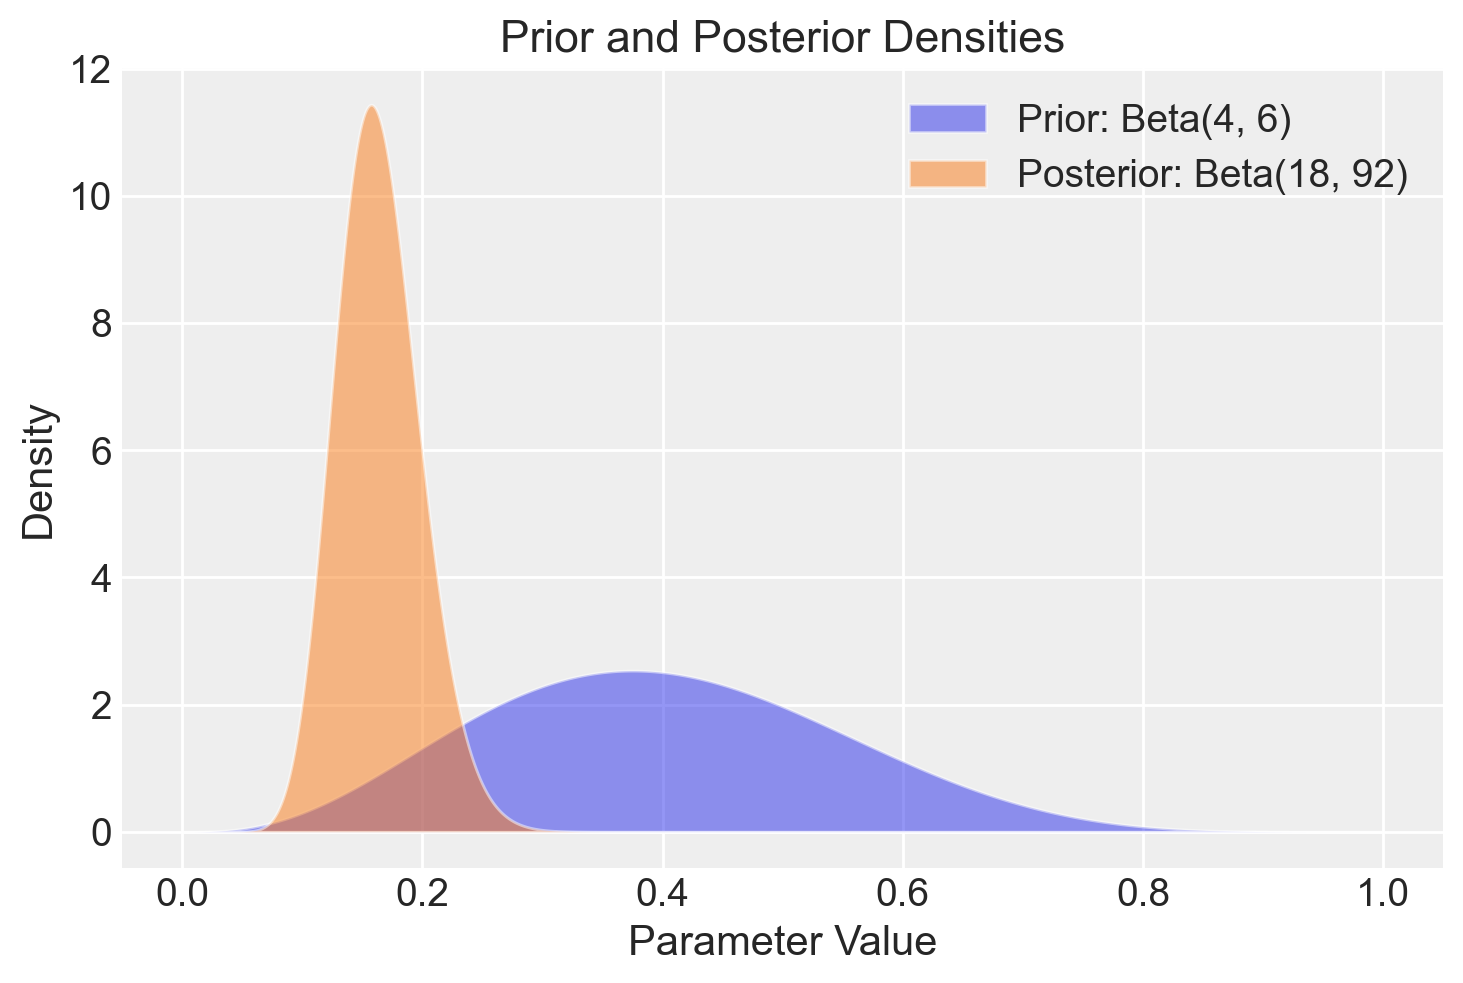

In [5]:
x = np.linspace(0, 1, 1000)

prior_density = stats.beta.pdf(x, 4, 6)
posterior_density = stats.beta.pdf(x, 18, 92)

plt.fill_between(x, prior_density, alpha=0.5, label="Prior: Beta(4, 6)")
plt.fill_between(x, posterior_density, alpha=0.5, label="Posterior: Beta(18, 92)")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.title("Prior and Posterior Densities")
plt.show()

Se vogliamo conoscere il valore della media a posteriori di $\theta$, il risultato esatto è

$$
\bar{\theta}_{post} = \frac{\alpha}{\alpha + \beta} = \frac{18}{18 + 92} \approx 0.1636.
$$

### Simulazione con distribuzione target nota

Usiamo ora una simulazione numerica per stimare la media a posteriori di $\theta$. Conoscendo la forma della distribuzione a posteriori $Beta(18, 92)$, possiamo generare un campione di osservazioni casuali da questa distribuzione. Successivamente, calcoliamo la media delle osservazioni ottenute per ottenere un'approssimazione della media a posteriori.

Se vogliamo ottenere un risultato approssimato con poche osservazioni (ad esempio, 10), possiamo procedere con la seguente simulazione:

In [6]:
y = stats.beta(18, 92).rvs(10)
print(y)

[0.12971627 0.15527801 0.14714901 0.20647646 0.1897427  0.16158686
 0.17558128 0.20738074 0.23121331 0.1330954 ]


In [7]:
np.mean(y)

0.17372200509655458

Tuttavia, con solo 10 campioni l'approssimazione potrebbe non essere molto accurata. Più aumentiamo il numero di campioni (cioè il numero di osservazioni casuali generate), più precisa sarà l'approssimazione. Aumentando il numero di campioni, ad esempio a 10000, otteniamo un risultato più preciso:

In [8]:
stats.beta(18, 92).rvs(10000).mean()

0.1635283857789979

Quando il numero di campioni a posteriori diventa molto grande, la distribuzione campionaria *converge* alla densità della popolazione. Questo concetto si applica non solo alla media, ma anche ad altre statistiche descrittive, come la moda e la varianza.

È importante sottolineare che l'applicazione della simulazione di Monte Carlo è efficace per calcolare distribuzioni a posteriori solo quando conosciamo la distribuzione stessa e possiamo utilizzare funzioni Python per estrarre campioni casuali da tale distribuzione. Ciò è stato possibile nel caso della distribuzione a posteriori $Beta(18, 92)$. 

Tuttavia, questa situazione ideale non si verifica sempre nella pratica, poiché le distribuzioni a priori coniugate alla verosimiglianza sono spesso rare. Per esempio, nel caso di una verosimiglianza binomiale e una distribuzione a priori gaussiana, l'espressione

$$
p(\theta \mid y) = \frac{\mathrm{e}^{-(\theta - 1 / 2)^2} \theta^y (1 - \theta)^{n - y}} {\int_0^1 \mathrm{e}^{-(t - 1 / 2)^2} t^y (1 - t)^{n - y} dt}
$$

rende impossibile calcolare analiticamente la distribuzione a posteriori di $\theta$, precludendo quindi l'utilizzo diretto di Python per generare campioni casuali.

In queste circostanze, però, è possibile ottenere campioni casuali dalla distribuzione a posteriori mediante l'uso di metodi Monte Carlo basati su Catena di Markov (MCMC). Gli algoritmi MCMC, come ad esempio l'algoritmo Metropolis, costituiscono una classe di metodi che consentono di estrarre campioni casuali dalla distribuzione a posteriori *senza richiedere la conoscenza della sua rappresentazione analitica*. Le tecniche MCMC sono ampiamente adottate per risolvere problemi di inferenza bayesiana e rappresentano il principale strumento computazionale per ottenere stime approssimate di distribuzioni a posteriori in situazioni complesse e non analiticamente trattabili.

### Algoritmo di Metropolis

L'algoritmo di Metropolis appartiene alla famiglia dei metodi Monte Carlo basati su catene di Markov (MCMC), sfruttando le proprietà di queste catene per generare campioni da una distribuzione target. Il suo obiettivo principale è di esplorare lo spazio dei parametri in modo efficiente, producendo campioni che approssimano la distribuzione a posteriori di interesse.

### Principio di Funzionamento
L'algoritmo inizia da un valore iniziale per i parametri e, in ogni iterazione, genera un nuovo campione tramite una distribuzione di proposta (solitamente una distribuzione normale centrata sul valore corrente). Successivamente, decide se accettare il nuovo campione in base al confronto tra le densità posteriori del nuovo campione e di quello precedente. Questa accettazione avviene in modo probabilistico, favorendo campioni con una densità più alta ma consentendo anche l'accettazione di campioni peggiori per evitare che la catena rimanga bloccata in minimi locali.

### Burn-in e Convergenza
Poiché i primi campioni potrebbero non rappresentare bene la distribuzione target, si esclude spesso una porzione iniziale della catena (fase di burn-in). Con il progredire delle iterazioni, i campioni si distribuiscono in accordo con la distribuzione stazionaria desiderata, indipendentemente dallo stato iniziale scelto. Questo processo permette di esplorare lo spazio dei parametri in modo efficiente.

### Meccanismo di Accettazione e Rifiuto
L'algoritmo di Metropolis bilancia due esigenze opposte:

1. **Esplorazione** di nuove aree dello spazio dei parametri.
2. **Sfruttamento** delle informazioni già acquisite dai campioni precedenti.

Utilizzando una regola probabilistica per accettare campioni peggiori (con minore densità a posteriori), l'algoritmo evita di restare intrappolato in minimi locali, esplorando così in modo più completo l'intera distribuzione.

### Passaggi Fondamentali dell'Algoritmo di Metropolis

1. **Scelta di uno stato iniziale $\theta_1$ e impostazione del contatore $t = 1$.**
   - Questo è il punto di partenza della catena, dove $\theta_1$ rappresenta il primo campione.

2. **Proposta di un nuovo campione $\theta_p$.**
   - Un nuovo valore $\theta_p$ viene generato da una distribuzione di proposta $g(\theta_p \mid \theta_t)$, solitamente una distribuzione normale centrata sul campione corrente $\theta_t$ con una deviazione standard $\tau$ che controlla l'ampiezza dei passi.

3. **Verifica dei vincoli del campione proposto.**
   - Se il nuovo campione deve rispettare dei vincoli (ad esempio, essere compreso tra 0 e 1 per probabilità), campioni non validi vengono automaticamente rifiutati.

4. **Calcolo del rapporto di accettazione $\alpha$.**
   - Si calcola $\alpha = \frac{p(\theta_p \mid y)}{p(\theta_t \mid y)}$, che rappresenta il rapporto tra le densità a posteriori del nuovo campione $\theta_p$ e del campione corrente $\theta_t$. Questo valore guida la decisione di accettazione.

5. **Decisione di accettazione.**
   - Se $\alpha \geq 1$, il nuovo campione $\theta_p$ viene accettato incondizionatamente.
   - Se $\alpha < 1$, il campione $\theta_p$ viene accettato con probabilità $\alpha$. In caso di rifiuto, si mantiene il campione corrente $\theta_t$ per la prossima iterazione.

6. **Ripetizione del processo.**
   - Si ripetono i passaggi dal 2 al 5 fino a ottenere il numero desiderato di campioni.

### Dettagli Aggiuntivi

- **Distribuzione di proposta**: La distribuzione di proposta $g(\theta_p \mid \theta_t)$ genera nuovi campioni attorno a $\theta_t$. Tipicamente si usa una normale $N(\theta_t, \tau)$, dove $\tau$ controlla quanto il nuovo campione si discosta da quello corrente. Scegliere un $\tau$ troppo piccolo può rendere l'esplorazione lenta, mentre un $\tau$ troppo grande può far rifiutare troppi campioni, riducendo l'efficienza.

- **Rapporto di accettazione $\alpha$**: Se il nuovo campione ha una densità a posteriori maggiore del campione corrente, viene sempre accettato. Se ha una densità inferiore, viene accettato con probabilità $\alpha$, il che consente di esplorare anche regioni meno probabili della distribuzione.

- **Accettazione probabilistica**: Accettare campioni peggiori occasionalmente aiuta l'algoritmo a evitare di bloccarsi in minimi locali. Questo è uno dei punti di forza dell'algoritmo di Metropolis, che garantisce una buona esplorazione dello spazio dei parametri.

## Esempio di Implementazione

Per la presente simulazione, ci serviremo dell'implementazione in Python proposta da [Elizaveta Semenova](https://elizaveta-semenova.com/), che offre una presentazione particolarmente concisa ed efficace della logica sottostante l'algoritmo. Iniziamo a definire alcune funzioni. 

Definiamo una funzione `prior` che accetta come argomento il valore di $\theta$ e restituisce la densità della distribuzione Beta(4, 6).

In [9]:
# Define prior distribution (Beta(4,6))
def prior(p):
    alpha = 4
    beta = 6
    return stats.beta.pdf(p, alpha, beta)

Definiamo la funzione `likelihood`, che accetta come argomento il valore di $\theta$ e restituisce la densità della funzione di verosimiglianza binomiale per il caso di 14 successi su 100 prove.

In [10]:
# Define likelihood function (Binomial with y = 14 successes out of n = 100 trials)
def likelihood(p):
    y = 14
    n = 100
    return stats.binom.pmf(y, n, p)

Infine, definiamo la funzione `posterior`, che accetta come argomento il valore di $\theta$ e restituisce la densità della distribuzione a posteriori non normalizzata, calcolata come il prodotto della distribuzione a priori e della verosimiglianza. 

In [11]:
# Define posterior as the product of prior and likelihood
def posterior(p):
    return likelihood(p) * prior(p)

Definiamo la distribuzione proposta come una distribuzione gaussiana centrata sullo stato corrente con deviazione standard definita a priori.

In [12]:
# Proposal distribution (normal distribution around current state)
def proposal_distribution(current_state, proposal_sigma):
    return np.random.normal(current_state, proposal_sigma)

Definiamo la distribuzione target che corrispone dalla distribuzione a posteriori.

In [13]:
# Target distribution is the posterior we are sampling from
def target_distribution(p):
    return posterior(p)

Procediamo ora con un'implementazione dell'algoritmo di Metropolis, considerando i dati relativi agli artisti della Generazione X presenti al MoMA. In questa simulazione, come indicato in precedenza, adottiamo una distribuzione a priori per $\theta$ (la probabilità di appartenere alla Generazione X) modellata secondo una (arbitraria) distribuzione Beta(4, 6).

In [14]:
# Metropolis-Hastings algorithm
def metropolis_hastings(num_samples, initial_state, proposal_sigma):
    # Start with the initial state and prepare to store samples
    samples = [initial_state]
    current_state = initial_state

    for _ in range(num_samples):
        # Propose a new state from a normal distribution around the current state
        proposed_state = proposal_distribution(current_state, proposal_sigma)

        # Ensure the proposed state is within valid bounds (between 0 and 1 for probabilities)
        if 0 <= proposed_state <= 1:
            # Calculate acceptance ratio
            acceptance_ratio = min(
                1,
                target_distribution(proposed_state)
                / target_distribution(current_state),
            )

            # Accept or reject the proposed state
            if np.random.uniform(0, 1) < acceptance_ratio:
                current_state = proposed_state

        # Append the current state (accepted or rejected) to the samples
        samples.append(current_state)

    return samples


Nell'implementazione dell'algoritmo di Metropolis proposta ci sono diversi punti cruciali da considerare, che contribuiscono al funzionamento e alla correttezza dell'algoritmo.

### Simmetria della Distribuzione Proposta
L'algoritmo di Metropolis richiede che la distribuzione di proposta sia simmetrica. Questo significa che la probabilità di proporre uno stato $\theta_p$ partendo da $\theta_t$ deve essere uguale alla probabilità di proporre $\theta_t$ partendo da $\theta_p$. Nel tuo caso, la distribuzione normale utilizzata ($N(\theta_t, \sigma)$) soddisfa questa condizione, poiché è simmetrica attorno al valore corrente $\theta_t$. È importante notare che questa condizione è necessaria per l'algoritmo di Metropolis, ma non per l'algoritmo di Metropolis-Hastings, che permette distribuzioni proposte asimmetriche.

### Scelta del Valore Iniziale
Il valore iniziale `initial_state` dovrebbe essere scelto con attenzione. Idealmente, questo valore dovrebbe trovarsi in una regione con alta densità della distribuzione a priori, in modo da facilitare la convergenza dell'algoritmo verso la distribuzione target. In alcuni casi, una scelta di partenza lontana dalla distribuzione a posteriori potrebbe richiedere un periodo di burn-in più lungo, poiché l'algoritmo impiega più tempo a esplorare lo spazio dei parametri e a stabilizzarsi.

### Gestione della Probabilità Zero
Un altro aspetto fondamentale è garantire che il nuovo campione proposto, `proposed_state`, rientri nei limiti del supporto della verosimiglianza e del prior. Nel tuo esempio, `proposed_state` è limitato all'intervallo [0, 1], come appropriato per i problemi di probabilità. Se il campione proposto cadesse al di fuori di questo intervallo, la densità a posteriori risulterebbe zero, causando un'accettazione impossibile o un rapporto indefinito.

## Meccanismo di Accettazione

Nel processo successivo alla generazione di un nuovo stato proposto, l'algoritmo deve decidere se accettare o meno questo stato in base alla sua **densità a posteriori**, calcolata come il prodotto tra la **verosimiglianza** e il **prior**. Questo confronto avviene nel seguente modo:

### Generazione del Nuovo Stato
Il nuovo stato `proposed_state` viene generato da una distribuzione di proposta centrata sullo stato corrente `current_state`. La deviazione standard della distribuzione, definita dal parametro `proposal_sigma`, determina quanto il nuovo stato può distanziarsi dallo stato attuale. In pratica, un valore di `proposal_sigma` troppo piccolo potrebbe rallentare l'esplorazione dello spazio dei parametri, mentre un valore troppo grande potrebbe portare a un tasso di rifiuto elevato.

### Confronto tra Stati
Il cuore dell'algoritmo è il confronto tra la densità a posteriori del nuovo stato (`proposed_state`) e quella dello stato corrente (`current_state`). Se il nuovo stato ha una densità a posteriori **maggiore o uguale** rispetto al vecchio stato, viene **sempre accettato**. Altrimenti, viene accettato con una probabilità data dal **rapporto di accettazione**.

### Calcolo del Rapporto di Accettazione
Il rapporto di accettazione $\alpha$ viene calcolato come:

$$
\alpha = \min\left(1, \frac{p(\text{proposed state})}{p(\text{current state})}\right),
$$

dove $p(\text{proposed state})$ è la densità a posteriori del nuovo stato e $p(\text{current state})$ è quella dello stato attuale. Se il nuovo stato ha una probabilità maggiore, sarà accettato. Se invece la sua probabilità è minore, verrà accettato con una probabilità pari a $\alpha$. In questo modo, lo schema probabilistico permette all'algoritmo di esplorare anche aree con minore densità, evitando di restare bloccato in minimi locali.

## Tasso di Accettazione e Efficienza

Uno degli aspetti cruciali nell'uso dell'algoritmo è il **tasso di accettazione**, ovvero il rapporto tra il numero di proposte accettate e il numero totale di proposte. Un tasso di accettazione troppo basso indica che l'algoritmo sta rifiutando troppi campioni e quindi l'esplorazione dello spazio dei parametri è inefficiente. Viceversa, un tasso di accettazione troppo alto potrebbe indicare che la distribuzione proposta non si sta spostando abbastanza tra le iterazioni, con il rischio di una convergenza lenta.

In generale, un **tasso di accettazione compreso tra il 20% e il 40%** è spesso considerato ottimale per garantire un buon bilanciamento tra esplorazione e efficienza.

## Esecuzione del Campionamento

Procediamo con l'esecuzione del campionamento, implementando l'algoritmo di Metropolis come precedentemente illustrato

In [15]:
initial_state = 0.5  # Starting at the midpoint of the probability range
proposal_sigma = 0.1  # Standard deviation for the proposal distribution
num_samples = 10000  # Number of samples to generate

samples = metropolis_hastings(num_samples, initial_state, proposal_sigma)

La funzione `metropolis_hastings()` accetta come input il numero `num_samples` di passi da simulare, il punto di partenza e la deviazione standard della distribuzione proposta gaussiana. Come output, restituisce una catena di valori del parametro, specificamente la sequenza $\theta^{(1)}, \theta^{(2)}, \ldots, \theta^{\text{nsamp}}$. 

## Aspetti computazionali

### Warm-up/Burn-in

Uno degli aspetti cruciali per la riuscita dell'algoritmo è il raggiungimento della stazionarietà da parte della catena. In genere, i primi 1000-5000 valori vengono scartati in quanto rappresentano il periodo di "burn-in" della catena. Dopo un determinato numero di passi $k$, la catena converge e i valori diventano campioni effettivi dalla distribuzione a posteriori $p(\theta \mid y)$.

### Sintesi della distribuzione a posteriori {#sec-moma-post-estimates}

L'array `samples` contiene 10000 valori di una catena di Markov. Escludiamo i primi 5000 valori considerati come burn-in e consideriamo i restanti 5000 valori come un campione casuale estratto dalla distribuzione a posteriori $p(\theta \mid y)$.

Mediante i valori della catena così ottenuta è facile trovare una stima a posteriori del parametro $\theta$. Per esempio, possiamo trovare la stima della media a posteriori.

In [51]:
burnin = int(num_samples * 0.5)
burnin

5000

In [36]:
np.mean(samples[burnin:])

0.16389183286201028

Oppure possiamo stimare la deviazione standard della distribuzione a posteriori.

In [12]:
np.std(samples[burnin:])

0.0353754937892814

Il trace plot indica che la catena inizia con un valore casuale per poi spostarsi rapidamente nell'area intorno a 0.16, che è l'area con alta densità a posteriori. Successivamente, oscilla intorno a quel valore per le iterazioni successive. Visualizziamo un *trace plot* dei primi 200 valori della catena di Markov.

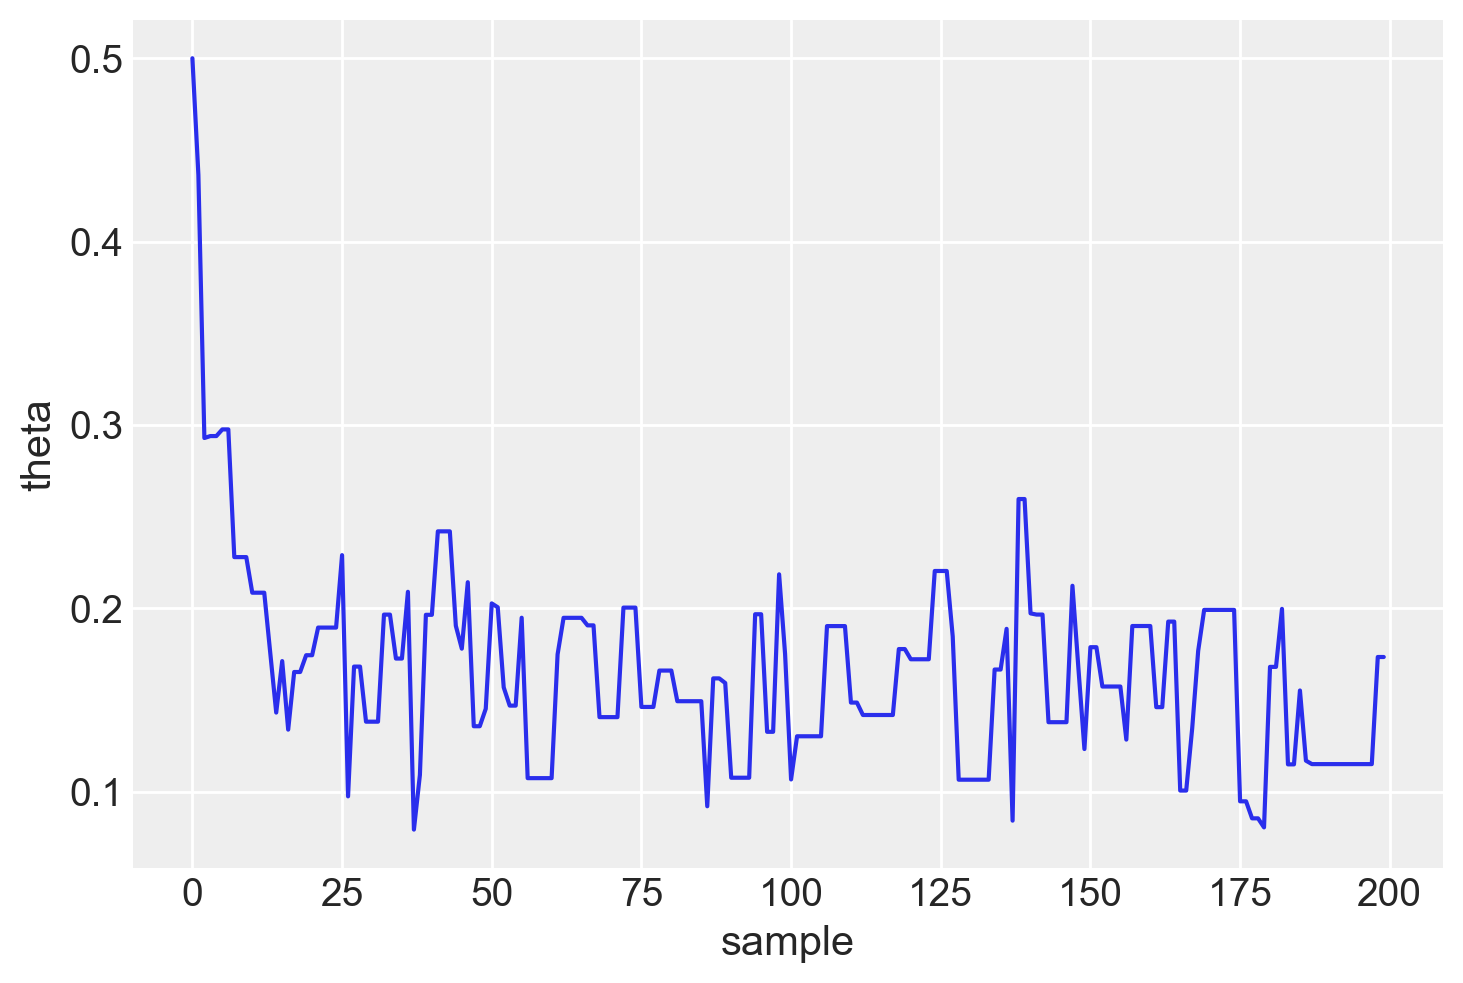

In [38]:
plt.plot(samples[0:200])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

Visualizziamo un *trace plot* dei valori della catena di Markov dopo il periodo di burn-in.

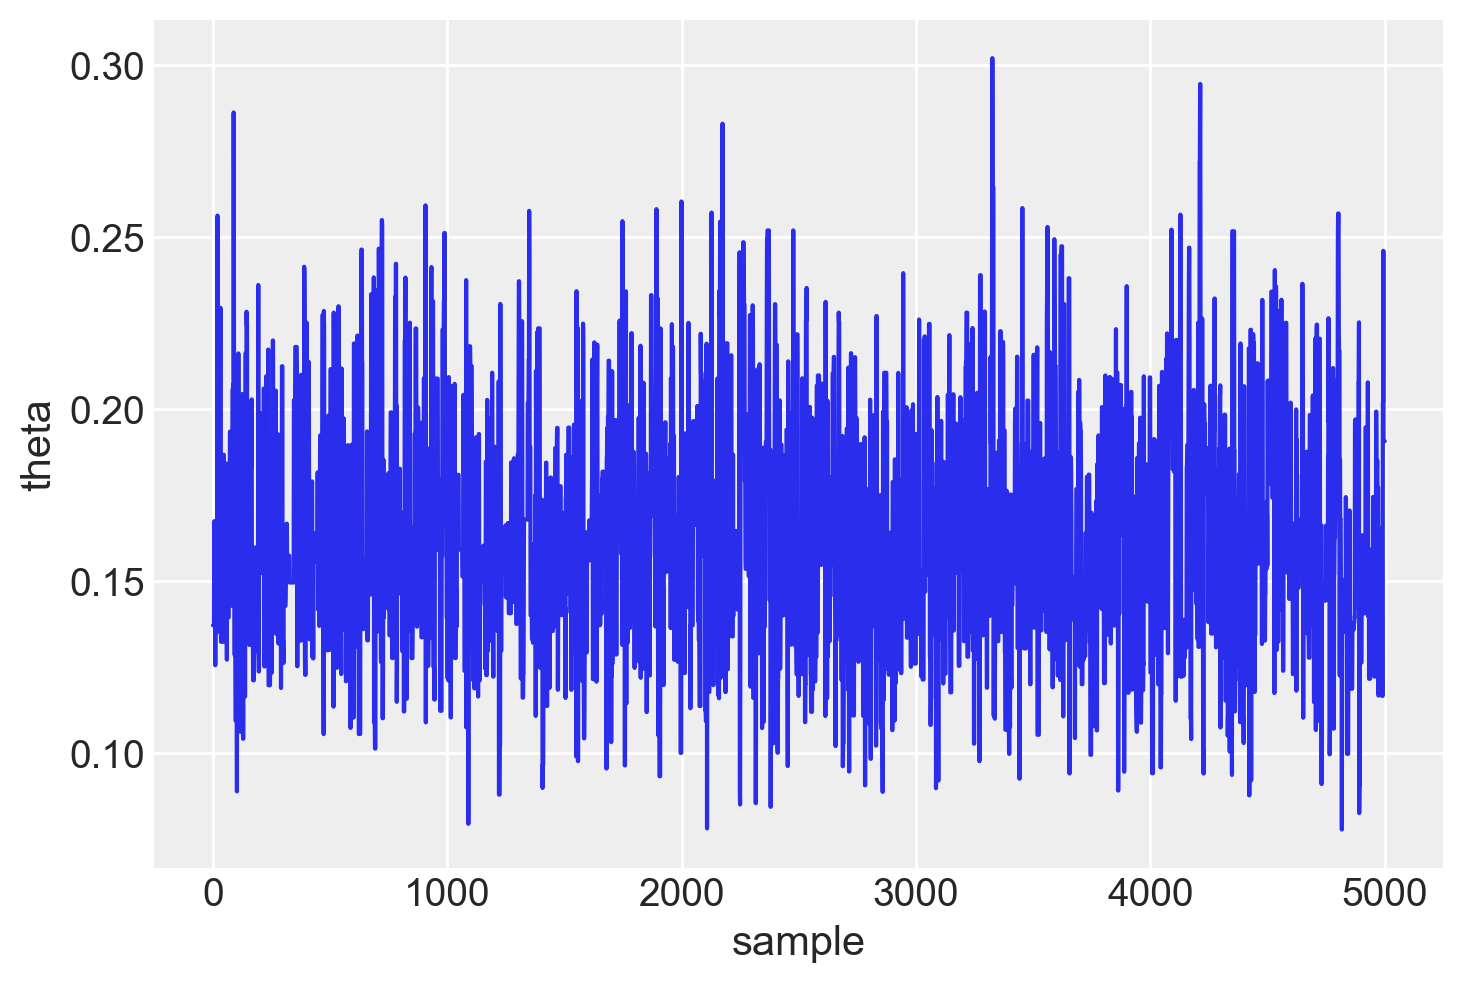

In [39]:
plt.plot(samples[burnin:])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

L'istogramma mostrato di seguito, sul quale è stata sovrapposta la distribuzione a posteriori derivata analiticamente -- specificamente una $\text{Beta}(25, 17)$ -- dimostra che la catena converge effettivamente alla distribuzione a posteriori desiderata.

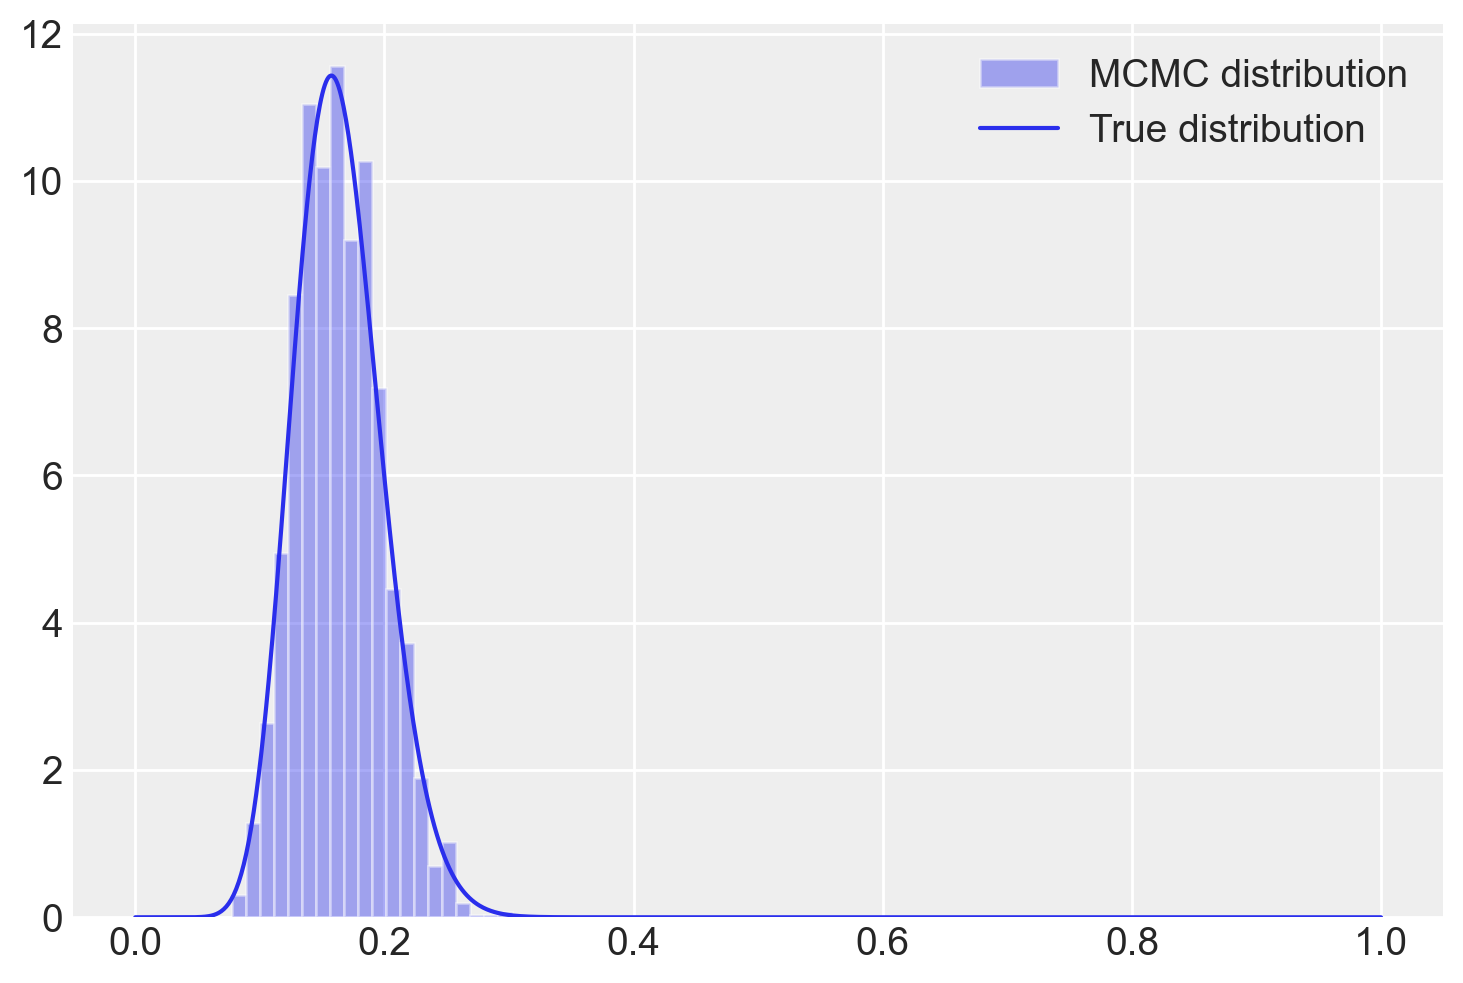

In [41]:
plt.hist(samples[burnin:], bins=20, alpha=0.4, label="MCMC distribution", density=True)
# plot the true function
x = np.linspace(0, 1, 1000)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

Come previsto, la distribuzione a posteriori calcolata con l'algorimo di Metropolis converge verso la soluzione analitica.

È possibile usare la funzione `summary` del pacchetto ArviZ per calolare l'intervallo di credibilità, ovvero l'intervallo che contiene la proporzione indicata dei valori estratti a caso dalla distribuzione a posteriori.

In [49]:
samples_array = np.array(samples) # per potere usare ArViZ
az.summary(samples_array[burnin:], kind="stats", hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%
x,0.16,0.03,0.11,0.23


Un KDE plot corrispondente all'istogramma precedente si può generare usando `az.plot_posterior()`. La curva  rappresenta l'intera distribuzione a posteriori e viene calcolata utilizzando la stima della densità del kernel (KDE) che serve a "lisciare" l'istogramma.

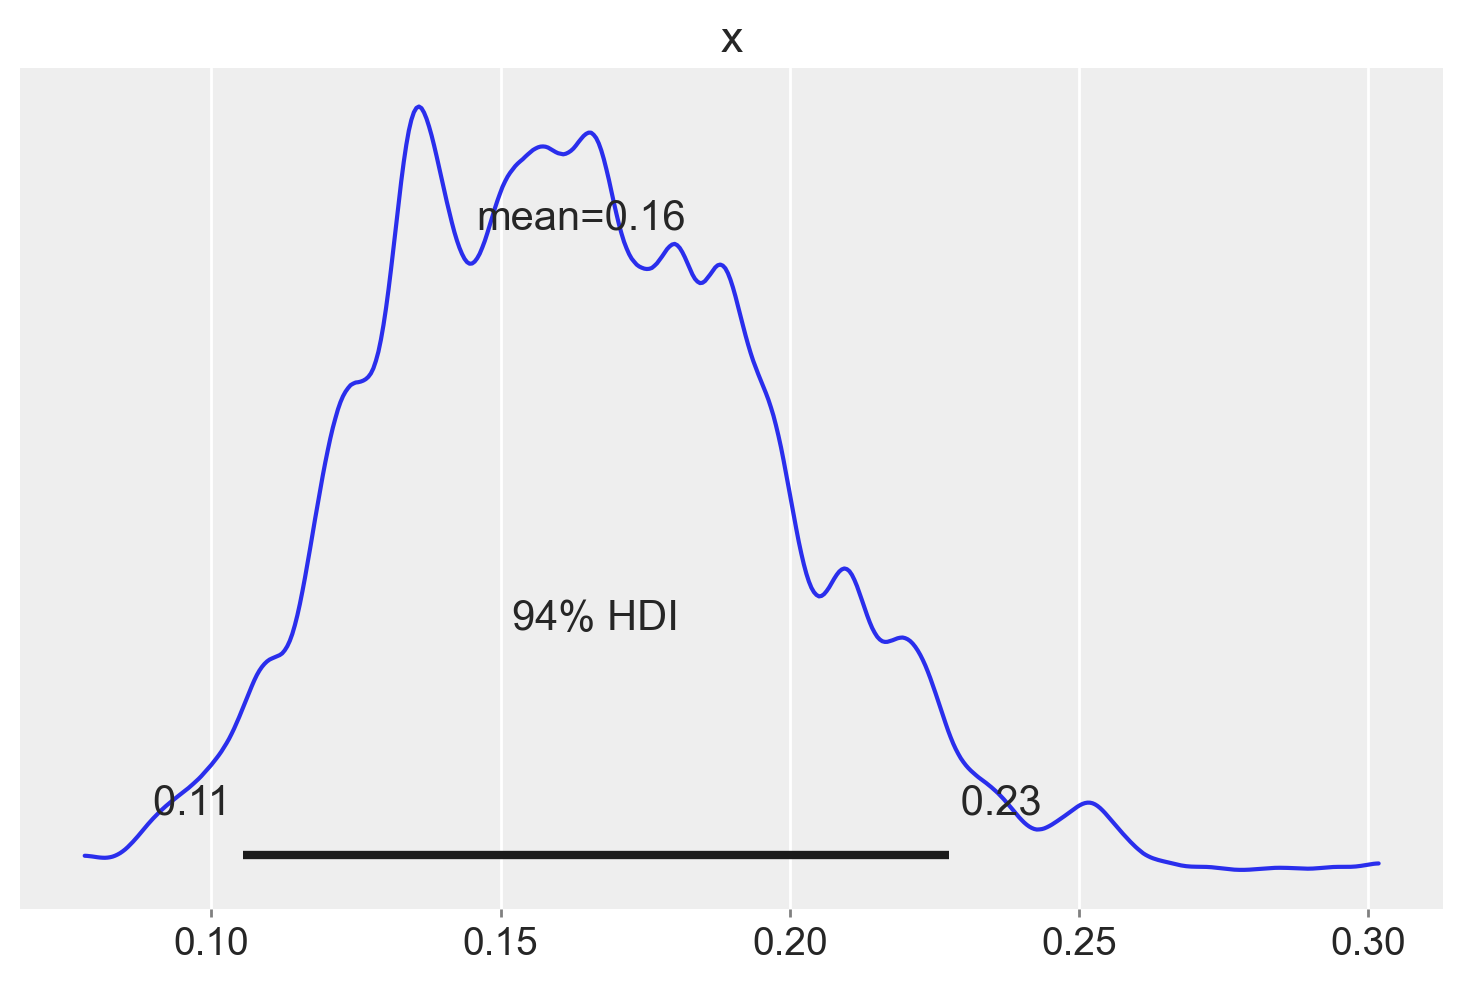

In [50]:
az.plot_posterior(samples_array[burnin:])
plt.show()

L'HDI è una scelta comune nelle statistiche bayesiane e valori arrotondati come 50% o 95% sono molto popolari. Ma ArviZ utilizza il 94% come valore predefinito. La ragione di questa scelta è che il 94% è vicino al valore ampiamente utilizzato del 95%, ma è anche diverso da questo, così da servire da "amichevole promemoria" che non c'è niente di speciale nella soglia del 5%. Idealmente sarebbe opportuno scegliere un valore che si adatti alle specifiche esigenze dell'analisi statistica che si sta svolgendo, o almeno riconoscere che si sta usando un valore arbitrario.

## Catene di Markov e Convergenza

Nell'ambito delle simulazioni Monte Carlo, una *catena* rappresenta una sequenza di valori campionati dall'algoritmo durante le sue iterazioni. Ogni valore nella catena corrisponde a un possibile stato del sistema che stiamo modellando. In altre parole, una catena traccia il percorso che l'algoritmo segue nello spazio dei parametri, esplorando le diverse configurazioni possibili.

Per verificare se l'algoritmo ha raggiunto la convergenza e se i campioni generati rappresentano effettivamente la distribuzione di interesse, è utile eseguire *multiple catene*. Ogni catena parte da un punto iniziale diverso nello spazio dei parametri.

**I vantaggi delle multiple catene:**

* **Diagnostica della convergenza:** Confrontando le diverse catene, possiamo valutare se si stabilizzano verso la stessa distribuzione. Se le catene si mescolano bene, ovvero si intersecano frequentemente nel grafico dei valori campionati (trace plot), è un forte indicatore di convergenza.
* **Robustezza:** L'utilizzo di multiple catene rende l'analisi meno sensibile alla scelta del punto di partenza. Se una singola catena potesse rimanere "intrappolata" in una regione dello spazio dei parametri, multiple catene aumentano la probabilità di esplorare lo spazio in modo più completo.

## Diagnostiche della soluzione MCMC

### Stazionarietà e Convergenza

Un aspetto cruciale nell'analisi delle catene di Markov MCMC è la **convergenza** alla **distribuzione stazionaria**. Intuitivamente, la catena converge quando i campioni generati rappresentano fedelmente la distribuzione di interesse, indipendentemente dal punto di partenza. Questo fenomeno è spesso indicato come "mixing".

#### Valutazione Visuale: Trace Plots e Grafici di Densità

* *Trace Plots:* Questi grafici visualizzano l'evoluzione dei parametri nel tempo. Una catena convergente mostra tracce stabili e senza trend evidenti. Tracce irregolari o con andamenti sistematici suggeriscono problemi di convergenza.
* *Grafici di Densità:* Confrontando i grafici di densità dei campioni con la distribuzione teorica, è possibile valutare visivamente se la catena sta esplorando adeguatamente lo spazio dei parametri. Una buona convergenza si manifesta con una sovrapposizione significativa tra i due grafici.

**Segni di Convergenza:**

* *Stabilità:* I valori campionati oscillano attorno a un valore medio costante, senza trend marcati.
* *Omogeneità:* La variabilità dei campioni rimane relativamente uniforme nel tempo.
* *Assenza di Periodicità:* Non si osservano pattern ciclici o ripetitivi.

In sintesi, i trace plots e i grafici di densità offrono strumenti visivi rapidi per valutare la convergenza di una catena di Markov MCMC. Una convergenza soddisfacente è fondamentale per garantire la validità delle inferenze statistiche basate sui campioni generati.

### Autocorrelazione nelle catene di Markov MCMC

A differenza dei generatori di numeri casuali indipendenti, gli algoritmi MCMC producono una sequenza di campioni *correlati*. Ogni valore campionato dipende da quello precedente, formando una *catena di Markov*. Questa interdipendenza è un aspetto fondamentale dell'MCMC.

L'*autocorrelazione* quantifica il grado di dipendenza tra valori distanti di una certa quantità (detta *lag*) nella catena. Un'alta autocorrelazione a lag bassi indica una forte dipendenza tra campioni successivi. Al contrario, una rapida diminuzione dell'autocorrelazione al crescere del lag suggerisce che la catena "miscela" bene, ovvero esplora lo spazio dei parametri in modo efficiente.

* *Lag 1:* Misura la correlazione tra valori consecutivi nella catena.
* *Lag 2:* Misura la correlazione tra valori separati da un passo intermedio.
* *Lag k:* Generalizza il concetto ai valori separati da k passi.

Un *correlogramma* è un grafico che mostra l'autocorrelazione in funzione del lag. Un decadimento rapido dell'autocorrelazione verso zero indica una buona convergenza della catena.

L'autocorrelazione di ordine $k$ è data da $\rho_k$ e può essere stimata come:

$$
\begin{align}
\rho_k &= \frac{Cov(\theta_m, \theta_{m+k})}{Var(\theta_m)}\notag\\
&= \frac{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})(\theta_{m-k} - \bar{\theta})}{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})^2} \qquad\text{con }\quad \bar{\theta} = \frac{1}{n}\sum_{m=1}^{n}\theta_m.
\end{align}
$$ {#eq-autocor}

Per fare un esempio pratico, simuliamo dei dati autocorrelati.

In [40]:
x = pd.array([22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51])
print(x)

<IntegerArray>
[22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]
Length: 15, dtype: Int64


L'autocorrelazione di ordine 1 è semplicemente la correlazione tra ciascun elemento e quello successivo nella sequenza.

In [41]:
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

Nell'esempio, il vettore `x` è una sequenza temporale di 15 elementi. Il vettore $x'$ include gli elementi con gli indici da 0 a 13 nella sequenza originaria, mentre il vettore $x''$ include gli elementi 1:14. Gli elementi delle coppie ordinate dei due vettori avranno dunque gli indici $(0, 1)$, $(1, 2), (2, 3), \dots (13, 14)$ degli elementi della sequenza originaria. La correlazione di Pearson tra i vettori $x'$ e $x''$ corrisponde all'autocorrelazione di ordine 1 della serie temporale.

Nell'output precedente

-   0.83174224 è l'autocorrelazione di ordine 1 (lag = 1),
-   0.65632458 è l'autocorrelazione di ordine 2 (lag = 2),
-   0.49105012 è l'autocorrelazione di ordine 3 (lag = 3),
-   ecc.

È possibile specificare il numero di ritardi (*lag*) da utilizzare con l'argomento `nlags`:

In [42]:
sm.tsa.acf(x, nlags=4)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962])

In Python possiamo creare un grafico della funzione di autocorrelazione (correlogramma) per una serie temporale usando la funzione `tsaplots.plot_acf()` dalla libreria `statsmodels`.

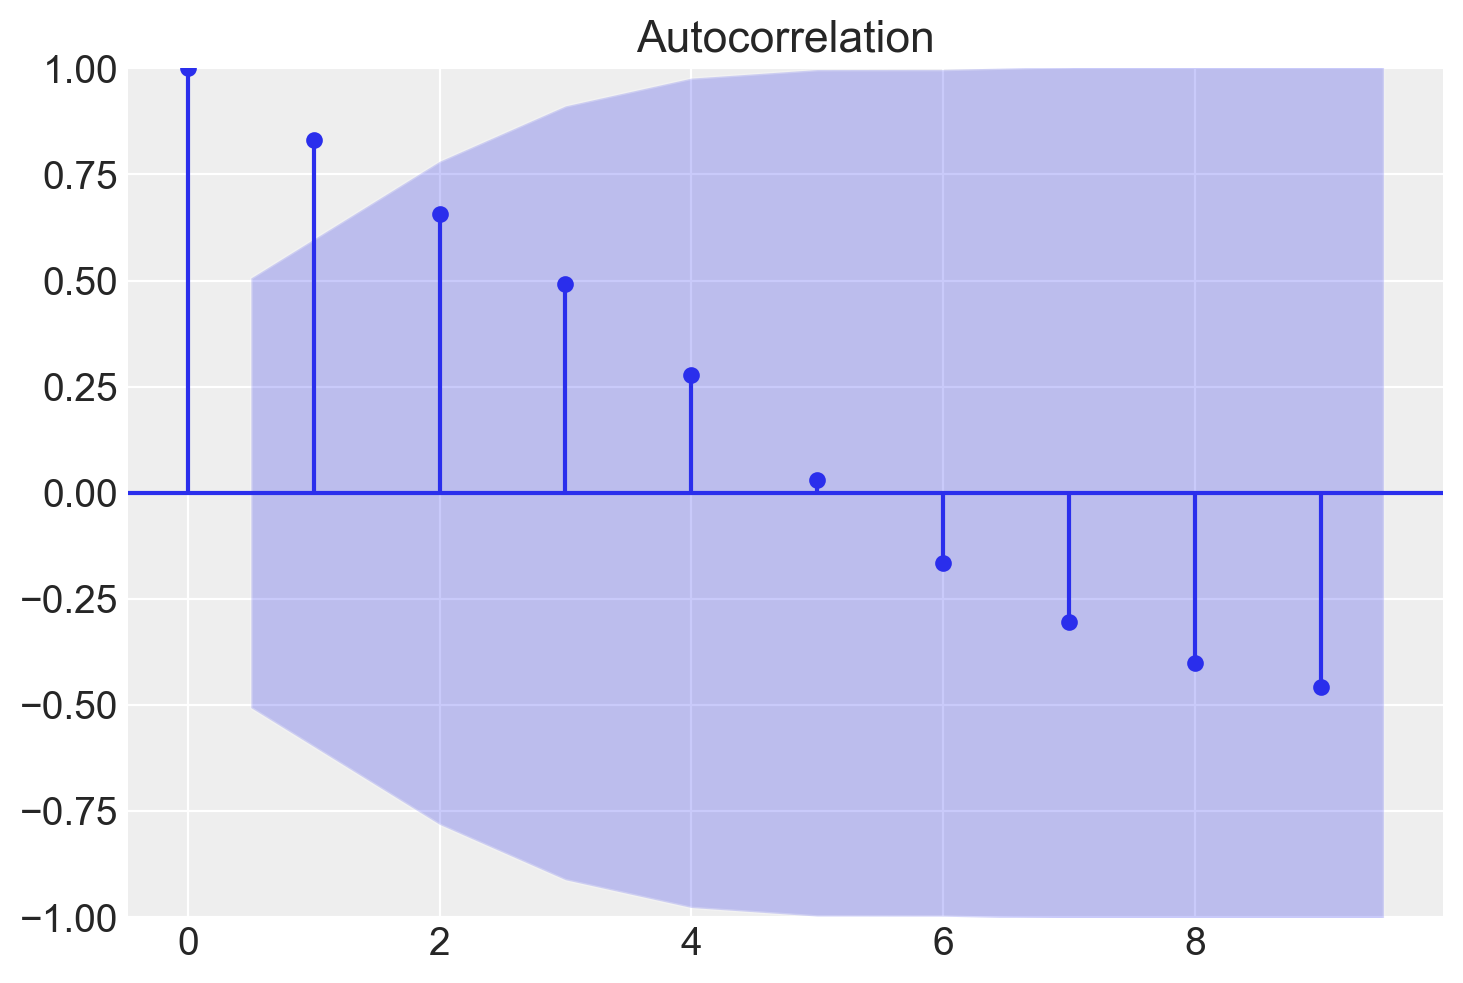

In [43]:
tsaplots.plot_acf(x, lags=9)
plt.show()

Per i dati dell'esempio in discussione otteniamo la situazione seguente.

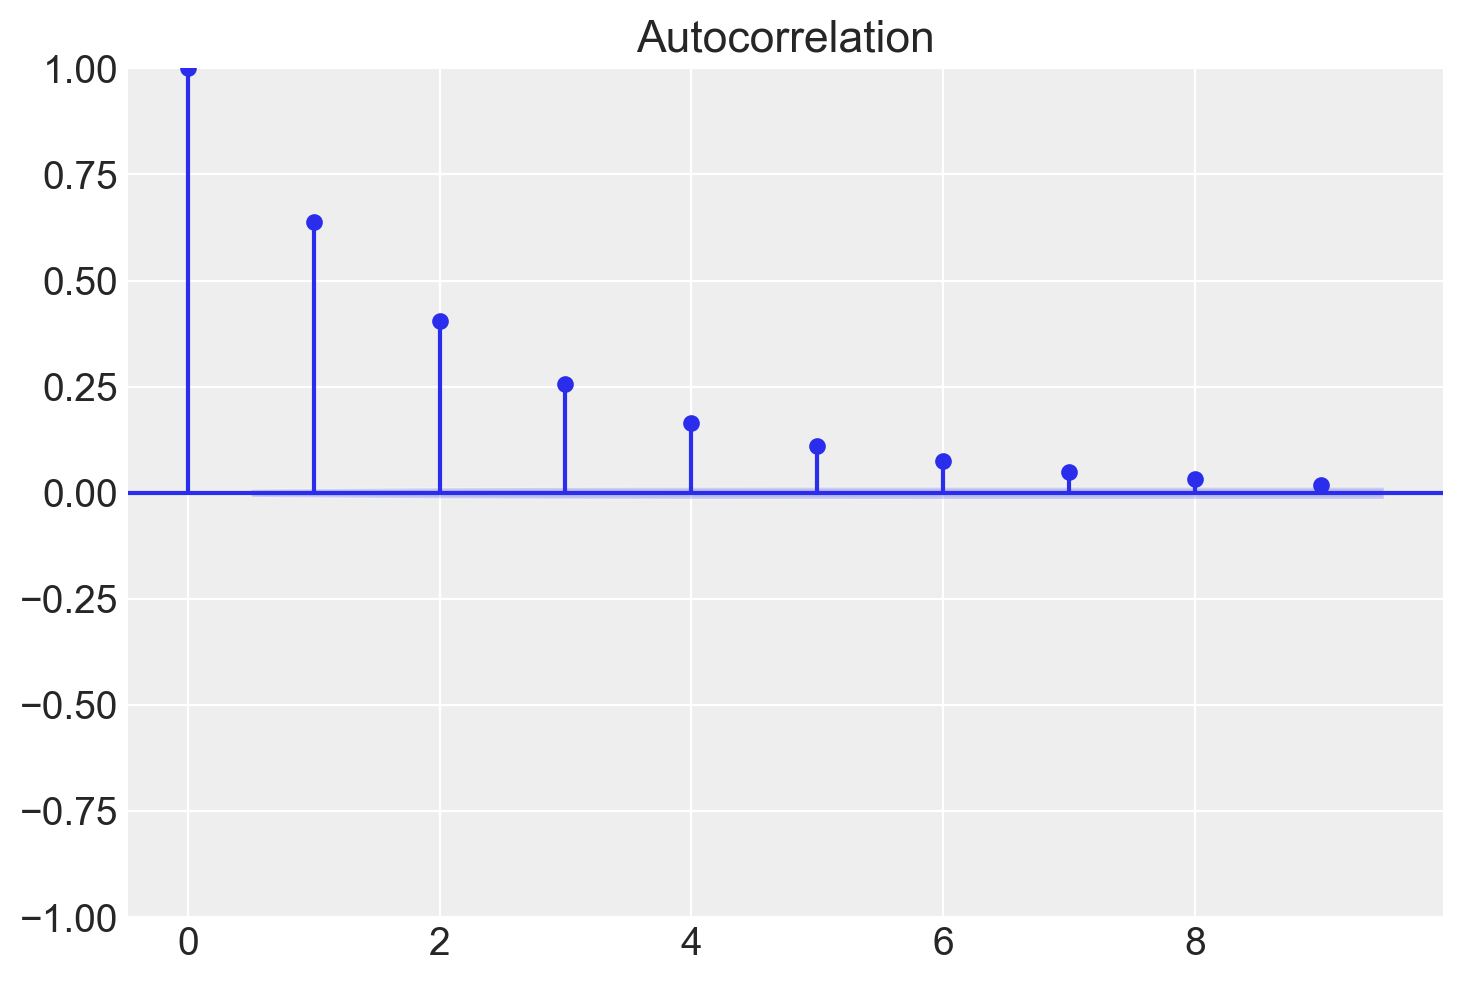

In [44]:
tsaplots.plot_acf(samps[burnin:], lags=9)
plt.show()

In situazioni ottimali l'autocorrelazione diminuisce rapidamente ed è effettivamente pari a 0 per piccoli lag. Ciò indica che i valori della catena di Markov che si trovano a più di soli pochi passi di distanza gli uni dagli altri non risultano associati tra loro, il che fornisce una conferma del "mixing" della catena di Markov, ossia della convergenza alla distribuzione stazionaria. Nelle analisi bayesiane, una delle strategie che consentono di ridurre l'autocorrelazione è quella di assottigliare l'output immagazzinando solo ogni $m$-esimo punto dopo il periodo di burn-in. Una tale strategia va sotto il nome di *thinning*.

Nel seguente correlogramma, analizziamo la medesima catena di Markov. Tuttavia, in questa occasione applichiamo un "thinning" (sottocampionamento) con un fattore di 5.

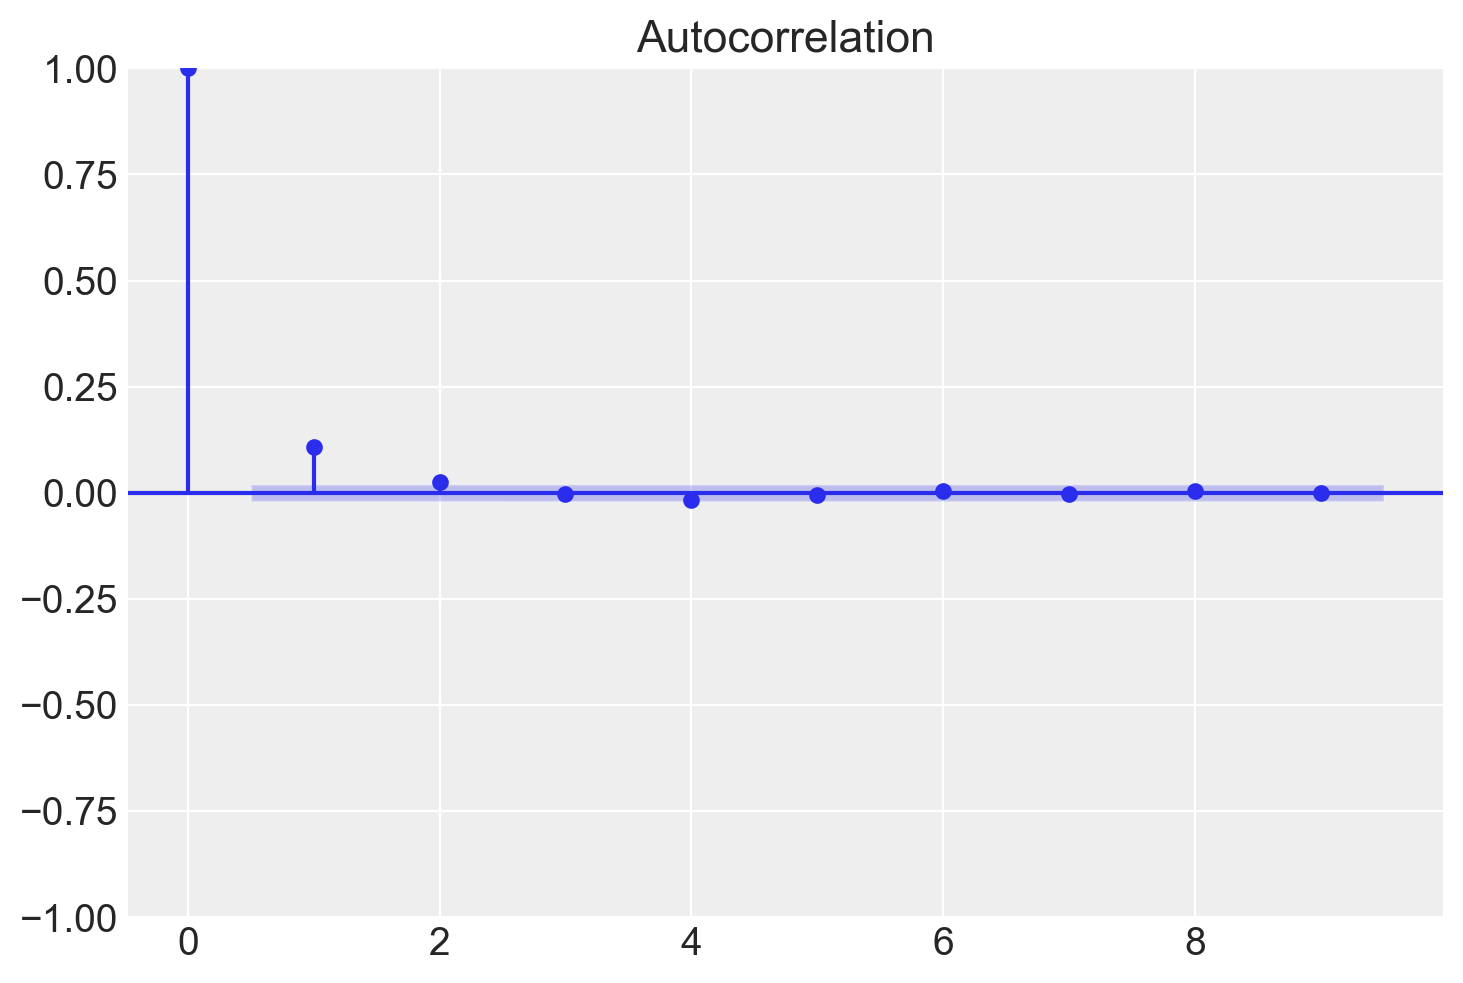

In [45]:
thin = 5
sampsthin = samps[burnin::thin]
tsaplots.plot_acf(sampsthin, lags=9)
plt.show()

Si può notare come l'autocorrelazione diminuisce molto più rapidamente.

#### Tasso di accettazione

Quando si utilizza l'algoritmo Metropolis, è importante monitorare il tasso di accettazione e assicurarsi che sia nell'intervallo ottimale. Se si accetta quasi sempre il candidato proposto, probabilmente significa che, in ogni iterazione, la catena salta solo di un piccolo passo (in modo che il rapporto di accettazione sia vicino a 1 ogni volta). Di conseguenza, la catena impiegherà molte iterazioni per raggiungere altre regioni della distribuzione stazionaria e i campioni consecutivi saranno molto fortemente correlati. D'altra parte, se il tasso di accettazione è molto basso, la catena rimarrà bloccata nella stessa posizione per molte iterazioni prima di spostarsi verso uno stato diverso. Per l'algoritmo Metropolis base con un singolo parametro con una distribuzione proposta Gaussiana normale, un tasso di accettazione ottimale è compreso tra il 40% e il 50%.

### Test Statistici per la Convergenza

Oltre agli approcci grafici, esistono test statistici specifici che possono aiutare a determinare se la catena ha raggiunto uno stato stazionario.

#### Test di Geweke

Il test di Geweke è una procedura che confronta le medie di due segmenti della catena di campionamento, tipicamente il primo 10% e l'ultimo 50% dei campioni, dopo aver escluso un iniziale periodo di "burn-in" (una fase iniziale durante la quale la catena potrebbe non essere ancora convergente). La premessa di base è che, se la catena è in uno stato stazionario, le medie di questi due segmenti dovrebbero essere sostanzialmente uguali. Differenze significative tra queste medie possono indicare che la catena non ha ancora raggiunto la convergenza.

#### Geweke Z-score

Una variante del test di Geweke è lo z-score di Geweke, che offre un modo quantitativo per valutare le differenze tra i segmenti della catena. Questo test calcola uno z-score che confronta le medie dei due segmenti tenendo conto della varianza. Un valore di z-score:

- **Al di sotto di 2 (in valore assoluto)** suggerisce che non ci sono differenze significative tra i segmenti, indicando che la catena potrebbe essere in stato stazionario.
- **Superiore a 2 (in valore assoluto)** indica che esiste una differenza significativa tra i segmenti, suggerendo che la catena non ha raggiunto la convergenza e potrebbe essere necessario un periodo di burn-in più esteso.

Entrambi i metodi forniscono strumenti utili per valutare la convergenza delle catene MCMC. È importante notare che nessun test può garantire con certezza la convergenza, ma l'utilizzo congiunto di approcci grafici e test statistici può offrire una buona indicazione dello stato della catena.

### Dimensione del campione effettiva (ESS)

La correlazione tra campioni consecutivi in una catena MCMC riduce l'informazione effettiva contenuta in ogni iterazione. La **dimensione del campione effettiva (ESS)** quantifica questa perdita di informazione dovuta alla dipendenza tra i campioni, stimando il numero equivalente di campioni indipendenti. Un valore basso di ESS indica una forte correlazione tra i campioni e una convergenza più lenta della catena.

L'ESS descrive l'efficacia del campionamento dipendente in termini di campioni indipendenti estratti dalla stessa distribuzione. Rappresenta un indicatore dell'efficienza del campionamento e dell'autocorrelazione della catena.

La formula per stimare la dimensione del campione effettiva (ESS) di una catena di Markov è:

$$
\text{ESS} = \frac{N}{1 + 2 \sum_{t=1}^{T} \rho_t},
$$

dove:

- $N$ è il numero totale di campioni nella catena,
- $T$ è il lag, ovvero il numero massimo di termini di autocorrelazione considerati,
- $\rho_t$ è l'autocorrelazione al lag $t$, ossia la correlazione tra due campioni consecutivi separati da $t$ iterazioni.

In pratica, $T$ viene scelto in modo tale che $\rho_T$ sia sufficientemente piccolo, indicando che l'autocorrelazione è quasi svanita. La somma $\sum_{t=1}^T \rho_t$ viene quindi troncata approssimativamente a $T$, poiché i contributi delle autocorrelazioni successive diventano trascurabili.

### Calcolo della Statistica di Gelman-Rubin ($\hat{R}$)

Per calcolare la statistica di Gelman-Rubin (spesso indicata come $\hat{R}$), è necessario eseguire più catene e confrontare la variabilità all'interno di ciascuna catena con la variabilità tra le catene. Ecco i passaggi per calcolare $\hat{R}$:

1. Esegui $m$ catene di Markov di lunghezza $n$, dove $m$ è solitamente maggiore di 1.
2. Per ciascun parametro scalare $\theta$, calcola la varianza all'interno delle catene ($W$) e la varianza tra le catene ($B$).
3. Calcola la varianza combinata $\hat{V}$ come media ponderata delle varianze all'interno delle catene.
4. Calcola il fattore di riduzione della scala potenziale $\hat{R}$ come la radice quadrata del rapporto tra la varianza combinata $\hat{V}$ e la varianza all'interno delle catene $W$:
    
    $$
    \hat{R} = \sqrt{\frac{\hat{V}}{W}}.
    $$
    
5. Se $\hat{R}$ è vicino a 1, ciò indica che le catene sono in convergenza.

La statistica di Gelman-Rubin $\hat{R}$ è una misura di convergenza per le catene di Markov. Essa quantifica il grado di accordo tra più catene, fornendo uno strumento diagnostico per valutare la convergenza nelle simulazioni MCMC.

## Vantaggi del Campionamento MCMC rispetto alle Soluzioni Analitiche

Il campionamento MCMC offre notevoli vantaggi pratici rispetto alle soluzioni analitiche nella statistica bayesiana, in particolare quando si tratta di manipolare distribuzioni a posteriori. Sebbene l'impossibilità di calcolare analiticamente la distribuzione a posteriori sia spesso la motivazione principale per l'uso di MCMC, i benefici di questo approccio si estendono ben oltre questa necessità [@buerkner2024brms].

### Facilità di Manipolazione e Flessibilità

Il vantaggio chiave del campionamento MCMC risiede nella semplicità con cui si possono manipolare i campioni ottenuti. Mentre le densità calcolate analiticamente possono richiedere trasformazioni matematiche complesse, i campioni MCMC possono essere facilmente trasformati con operazioni dirette. Questa flessibilità si manifesta in diversi aspetti:

1. **Trasformazioni di Variabili**: 
   Consideriamo un caso in cui siamo interessati alla varianza residua ($\sigma^2$) in un modello, ma abbiamo campioni solo della deviazione standard residua ($\sigma$). Con il campionamento MCMC, la trasformazione è immediata:

   $$
   (\sigma^{(s)})^2 = \sigma^{2(s)},
   $$

   dove $s$ indica il singolo campione. Questa operazione si traduce semplicemente nell'elevare al quadrato ogni campione di $\sigma$, ottenendo direttamente campioni validi di $\sigma^2$. In contrasto, con una densità analitica di $\sigma$, la trasformazione richiederebbe l'applicazione dell'aggiustamento del Jacobiano, un processo matematicamente più complesso.

2. **Combinazione di Parametri**:
   Il MCMC semplifica notevolmente la combinazione di parametri in modelli statistici. Per una quantità $\theta$ che dipende da parametri $\beta_1$ e $\beta_2$ attraverso una funzione $f$, possiamo calcolare:

   $$\theta^{(s)} = f(\beta_1^{(s)}, \beta_2^{(s)}).$$

   Questa operazione si estende facilmente a combinazioni complesse e funzioni non lineari, contrastando nettamente con la complessità di derivare analiticamente la distribuzione di $\theta$.

In conclusione, il campionamento MCMC non è solo una necessità quando le soluzioni analitiche sono introvabili, ma offre vantaggi in termini di facilità di manipolazione, flessibilità computazionale e applicabilità pratica. 

## Caso Normale-Normale

Per fare un altro esempio, consideriamo ora il caso Normale-Normale di cui è possibile trovare una soluzione analitica. Supponiamo, come prior, una $\mathcal{N}(30, 5$.

In [46]:
def prior(mu):
    return stats.norm.pdf(mu, 30, 5)

Per la verosimiglianza del parametro $\mu$, supponiamo $\sigma$ nota e uguale alla deviazione standard del campione.

In [47]:
def likelihood(mu, data):
    std_data = np.std(data)  # Calcola la deviazione standard dei dati
    return np.prod(stats.norm.pdf(data, mu, std_data))

Definiamo il posterior non normalizzato:

In [48]:
def posterior(mu, data):
    return likelihood(mu, data) * prior(mu)

Modifichiamo ora l'algoritmo di Metropolis descritto sopra per adattarlo al caso presente.

In [49]:
# Algoritmo di Metropolis per il caso normale-normale
def metropolis_for_normal(nsamp, xinit, data):
    samples = np.empty(nsamp)
    x_prev = xinit

    for i in range(nsamp):
        x_star = np.random.normal(x_prev, 0.5)  # Genera un nuovo punto dalla proposta

        # Calcola il rapporto di accettazione e accetta il nuovo punto con una certa probabilità
        if posterior(x_star, data) / posterior(x_prev, data) > np.random.uniform():
            x_prev = x_star

        samples[i] = x_prev

    return samples

Vediamo cosa fa la presente versione dell'algoritmo di Metropolis passo dopo passo:

1. **Ciclo sui Campioni**: `for i in range(nsamp):` inizia un ciclo che si ripeterà `nsamp` volte, dove `nsamp` è il numero totale di campioni che vogliamo generare. Ogni iterazione di questo ciclo produrrà un campione dalla distribuzione di interesse.

2. **Generazione di un Nuovo Punto**: `x_star = np.random.normal(x_prev, 0.5)` genera un nuovo punto (`x_star`) come proposta per il prossimo passo del campionamento. Questo è fatto campionando da una distribuzione normale con media uguale all'ultimo punto accettato (`x_prev`) e una deviazione standard di `0.5`. Questa distribuzione è detta distribuzione di proposta e serve a esplorare lo spazio dei parametri.

3. **Calcolo del Rapporto di Accettazione**: 
    - Il rapporto di accettazione è calcolato come `posterior(x_star, data) / posterior(x_prev, data)`, che è il rapporto tra la probabilità del posterior del nuovo punto proposto (`x_star`) e la probabilità del posterior dell'ultimo punto accettato (`x_prev`).
    - Questo rapporto indica quanto sia preferibile il nuovo punto rispetto al precedente, basandosi sulla funzione `posterior`, che calcola la probabilità a posteriori del modello dato il parametro e i dati osservati.

4. **Decisione di Accettazione del Nuovo Punto**: 
    - La decisione se accettare o meno il nuovo punto (`x_star`) si basa su un confronto del rapporto di accettazione con un numero casuale uniformemente distribuito tra 0 e 1 (`np.random.uniform()`).
    - Se il rapporto di accettazione è maggiore di questo numero casuale, il nuovo punto è accettato come il prossimo punto nella catena (`x_prev = x_star`). Ciò significa che il nuovo punto ha una probabilità a posteriori più alta rispetto al punto precedente, o è stato "fortunato" nel processo di selezione casuale, consentendo all'algoritmo di esplorare lo spazio dei parametri anche in zone di minore probabilità.
    - Se il nuovo punto non viene accettato, la catena rimane nel punto precedente (`x_prev`), e questo punto viene nuovamente aggiunto all'array dei campioni.

5. **Salvataggio del Campione**: `samples[i] = x_prev` salva il punto corrente (che può essere il nuovo punto accettato o il punto precedente se il nuovo punto è stato rifiutato) nell'array `samples`. Questo processo si ripete fino a quando non si raggiunge il numero desiderato di campioni.

Come dati, usiamo il campione di 30 valori BDI-II ottenuti dai soggetti clinici esaminati da {cite}`zetsche_2019future`.

In [50]:
y = np.array([
    26.0, 35.0, 30, 25, 44, 30, 33, 43, 22, 43, 24, 19, 39, 31, 25, 28, 35, 30, 26, 31,
    41, 36, 26, 35, 33, 28, 27, 34, 27, 22,
])

Procediamo con l'esecuzione dell'algoritmo di Metropolis.

In [51]:
samples = metropolis_for_normal(100_000, np.mean(y), y)
samples.shape

(100000,)

### Calcolo dei Parametri del Posterior Analitico

Nel caso normale-normale, possiamo derivare analiticamente la distribuzione posteriore quando sia il prior che la likelihood sono distribuzioni normali. La bellezza di questo approccio sta nella forma chiusa del posterior, che è anch'esso una distribuzione normale con parametri specifici facilmente calcolabili. Ecco come si fa:

1. **Media Posteriore ($\mu_{post}$)**: La media del posterior è un peso tra la media del campione e la media del prior, dove i pesi sono determinati dalle varianze del prior e dei dati.
   
   $$ 
   \mu_{post} = \frac{\frac{\mu_{prior}}{\sigma_{prior}^2} + \frac{\sum y_i}{\sigma_{data}^2}}{\frac{1}{\sigma_{prior}^2} + \frac{n}{\sigma_{data}^2}} 
   $$

2. **Varianza Posteriore ($\sigma_{post}^2$)**: La varianza del posterior è determinata dalle varianze del prior e dei dati.
   
   $$ 
   \sigma_{post}^2 = \left(\frac{1}{\sigma_{prior}^2} + \frac{n}{\sigma_{data}^2}\right)^{-1} 
   $$

Dove:
- $\mu_{prior}$ è la media del prior (in questo caso, 30),
- $\sigma_{prior}^2$ è la varianza del prior ($5^2$ in questo caso),
- $\sigma_{data}^2$ è la varianza dei dati (calcolata dai dati),
- $n$ è il numero di osservazioni,
- $\sum y_i$ è la somma delle osservazioni.

### Codice per il Grafico

Per produrre il grafico con l'istogramma dei campioni dal posterior (usando l'algoritmo di Metropolis) e la curva della distribuzione posteriore analitica, usiamo i parametri calcolati:

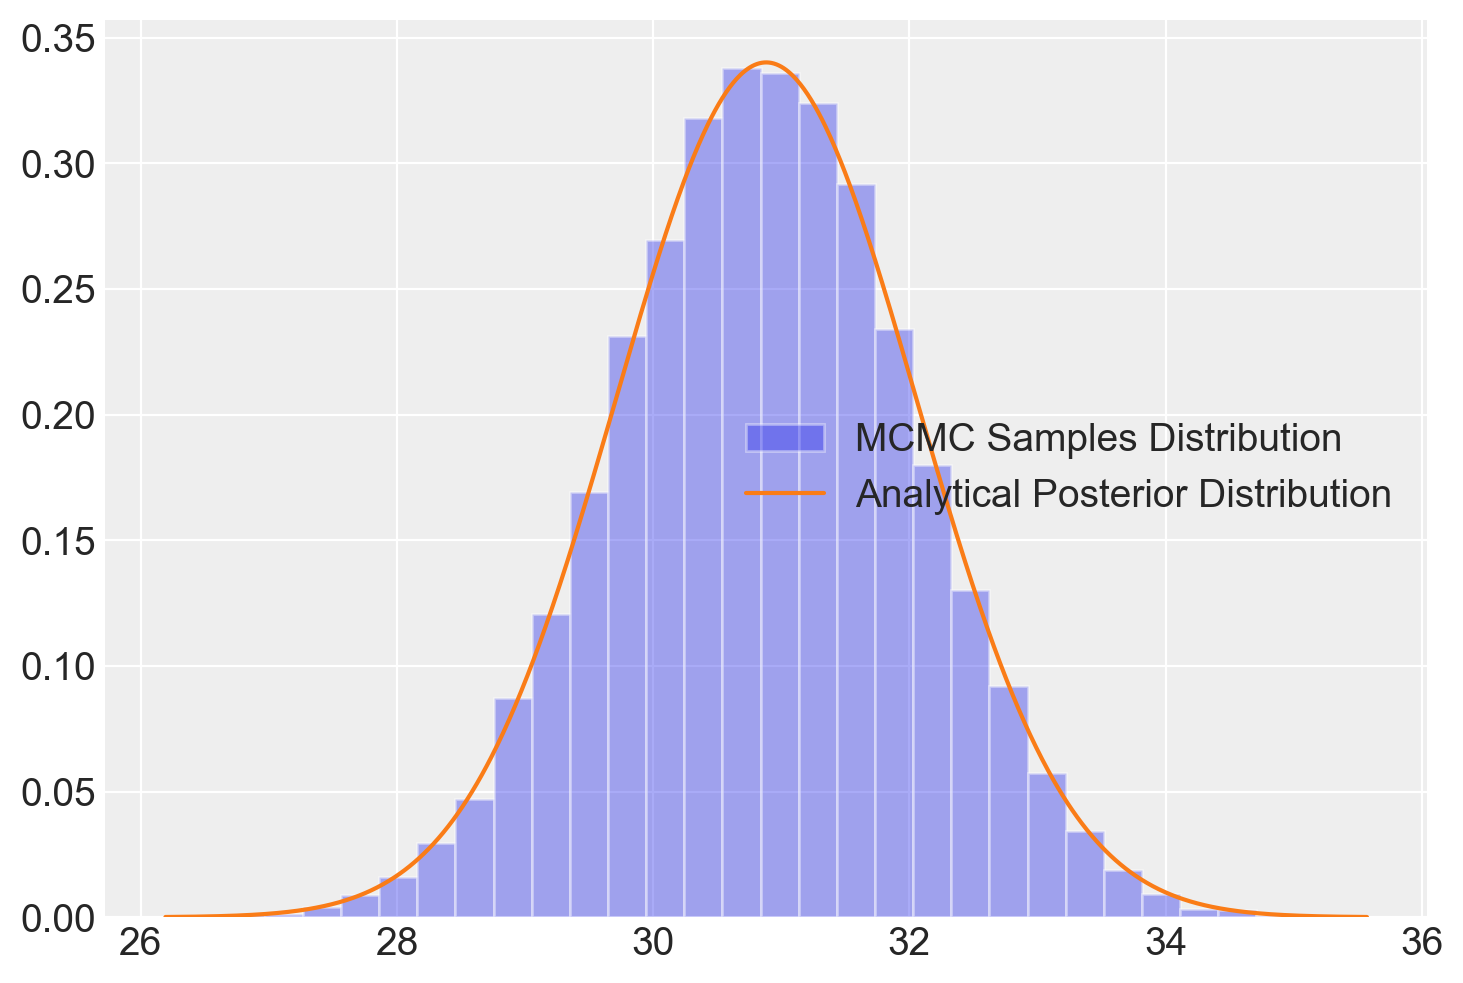

In [52]:
# Parametri del prior
mu_prior = 30
std_prior = 5
var_prior = std_prior ** 2

# Dati osservati
n = len(y)
sum_y = np.sum(y)
var_data = np.var(y, ddof=1)  # ddof=1 for sample variance

# Calcolo dei parametri posterior
mu_post = (mu_prior / var_prior + sum_y / var_data) / (1 / var_prior + n / var_data)
var_post = 1 / (1 / var_prior + n / var_data)
std_post = np.sqrt(var_post)

# Generazione dei punti x per il grafico
x = np.linspace(mu_post - 4 * std_post, mu_post + 4 * std_post, 1000)

# Istogramma dei campioni dal posterior
plt.hist(samples[burnin:], bins=30, alpha=0.4, density=True, label="MCMC Samples Distribution")

# Curva della distribuzione posteriore analitica
plt.plot(x, stats.norm.pdf(x, mu_post, std_post), "C1", label="Analytical Posterior Distribution")

plt.legend()
plt.show()

Questo codice mostra come integrare l'analisi MCMC con l'approccio analitico per il caso normale-normale, offrendo sia una visualizzazione dei risultati del sampling che la conferma attraverso la soluzione analitica. 

## Commenti e Considerazioni Finali

In molti casi, la distribuzione a posteriori dei parametri di un modello statistico non ha una forma analitica risolvibile. Per affrontare questa limitazione, si utilizzano metodi Monte Carlo basati su catene di Markov (MCMC). Questi algoritmi permettono di campionare efficacemente dalla distribuzione a posteriori, anche per modelli complessi, generando una sequenza di valori che approssima la distribuzione desiderata. L'algoritmo di Metropolis-Hastings [@hastings_1970], un'estensione dell'algoritmo di Metropolis originale [@metropolist_etal_1953], è uno dei metodi MCMC più ampiamente utilizzati.

In sintesi, l'algoritmo segue questi passaggi principali:

- **Generazione del nuovo stato proposto**: Si crea un nuovo stato vicino a quello corrente utilizzando una distribuzione di proposta.
- **Confronto tra densità posteriori**: Si confrontano le densità a posteriori del nuovo stato proposto e dello stato corrente.
- **Accettazione probabilistica**: Il nuovo stato viene sempre accettato se ha una densità posteriore maggiore, oppure accettato con una certa probabilità se ha una densità minore.
- **Burn-in e tasso di accettazione**: I primi campioni vengono scartati (fase di burn-in) per garantire che la catena abbia raggiunto la distribuzione stazionaria, e si monitora il tasso di accettazione per ottimizzare l'efficienza del campionamento.

Questo approccio consente di ottenere campioni che approssimano la distribuzione a posteriori, ma l'algoritmo di Metropolis può presentare limiti di efficienza, soprattutto per problemi ad alta dimensionalità o distribuzioni con geometrie complesse. Un aspetto cruciale è il **tasso di accettazione**, che rappresenta il rapporto tra il numero di proposte accettate e il numero totale di proposte. Un tasso troppo basso può indicare che la catena esplora lo spazio dei parametri in modo inefficiente, mentre un tasso troppo alto può segnalare che i passi effettuati sono troppo piccoli per consentire una buona esplorazione.

Rispetto alle varianti più moderne, l'algoritmo di Metropolis tende a essere meno efficiente. Metodi come il **No-U-Turn Sampler (NUTS)** e l'**Hamiltonian Monte Carlo (HMC)** offrono miglioramenti significativi, specialmente in spazi di parametri di grandi dimensioni. NUTS, ad esempio, viene utilizzato in strumenti avanzati come **Stan** e **PyMC** [@hoffman2014no], permettendo un'esplorazione più rapida e accurata della distribuzione a posteriori.

Tra gli altri algoritmi MCMC degni di nota troviamo il **campionatore di Gibbs** [@geman_geman_1984] e l'**Hamiltonian Monte Carlo** [@duane1987hybrid]. Questi metodi, insieme a Metropolis-Hastings, formano la base di numerose tecniche moderne per il campionamento da distribuzioni complesse. Per un approfondimento dettagliato sulle tecniche MCMC, si consiglia di consultare @hanada2022mcmc.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [53]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sat Jun 15 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

sys        : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]
matplotlib : 3.8.4
arviz      : 0.18.0
statsmodels: 0.14.2
scipy      : 1.13.1
numpy      : 1.26.4
seaborn    : 0.13.2
pymc       : 5.15.1
pandas     : 2.2.2

Watermark: 2.4.3

